# claudette

> Claudette is Claude's friend

In [ ]:
#| hide

from nbdev import show_doc
from fastcore.utils import *
from IPython.display import Image,display

> **NB**: If you are reading this in GitHub's readme, we recommend you instead read the much more nicely formatted [documentation format](https://claudette.answer.ai/) of this tutorial.

*Claudette* is a wrapper for Anthropic's [Python SDK](https://github.com/anthropics/anthropic-sdk-python).

The SDK works well, but it is quite low level -- it leaves the developer to do a lot of stuff manually. That's a lot of extra work and boilerplate! Claudette automates pretty much everything that can be automated, whilst providing full control. Amongst the features provided:

- A `Chat` class that creates stateful dialogs
- Support for *prefill*, which tells Claude what to use as the first few words of its response
- Convenient image support
- Simple and convenient support for Claude's new Tool Use API.

You'll need to set the `ANTHROPIC_API_KEY` environment variable to the key provided to you by Anthropic in order to use this library.

Note that this library is the first ever "literate nbdev" project. That means that the actual source code for the library is a rendered Jupyter Notebook which includes callout notes and tips, HTML tables and images, detailed explanations, and teaches *how* and *why* the code is written the way it is. Even if you've never used the Anthropic Python SDK or Claude API before, you should be able to read the source code. Click [Claudette's Source](https://claudette.answer.ai/core.html) to read it, or clone the git repo and execute the notebook yourself to see every step of the creation process in action. The tutorial below includes links to API details which will take you to relevant parts of the source. The reason this project is a new kind of literal program is because we take seriously Knuth's call to action, that we have a "*moral commitment*" to never write an "*illiterate program*" -- and so we have a commitment to making literate programming an easy and pleasant experience. (For more on this, see [this talk](https://www.youtube.com/watch?v=rX1yGxJijsI) from Hamel Husain.)

> "*Let us change our traditional attitude to the construction of programs: Instead of imagining that our main task is to instruct a **computer** what to do, let us concentrate rather on explaining to **human beings** what we want a computer to do.*" Donald E. Knuth, [Literate Programming](https://www.cs.tufts.edu/~nr/cs257/archive/literate-programming/01-knuth-lp.pdf) (1984)

## Install

```sh
pip install claudette
```

## Getting started

Anthropic's Python SDK will automatically be installed with Claudette, if you don't already have it.

In [ ]:
import os
# os.environ['ANTHROPIC_LOG'] = 'debug'

To print every HTTP request and response in full, uncomment the above line.

In [ ]:
from claudette import *

Claudette only exports the symbols that are needed to use the library, so you can use `import *` to import them. Alternatively, just use:

```python
import claudette
```

...and then add the prefix `claudette.` to any usages of the module.

Claudette provides `models`, which is a list of models currently available from the SDK.

In [ ]:
models

['claude-opus-4-20250514',
 'claude-sonnet-4-20250514',
 'claude-3-opus-20240229',
 'claude-3-7-sonnet-20250219',
 'claude-3-5-sonnet-20241022']

For these examples, we'll use Sonnet 4, since it's awesome!

In [ ]:
model = models[1]
model

'claude-sonnet-4-20250514'

## Chat

The main interface to Claudette is the `Chat` class, which provides a stateful interface to Claude:

In [ ]:
chat = Chat(model, sp="""You are a helpful and concise assistant.""")
chat("I'm Jeremy")

Hello Jeremy! Nice to meet you. How can I help you today?

<details>

- id: `msg_01Qszixu9YSaBj4CLXQiT6EA`
- content: `[{'citations': None, 'text': 'Hello Jeremy! Nice to meet you. How can I help you today?', 'type': 'text'}]`
- model: `claude-sonnet-4-20250514`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 19, 'output_tokens': 18, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

In [ ]:
r = chat("What's my name?")
r

Your name is Jeremy.

<details>

- id: `msg_01VQYxKWJfpDQF4E2oFEccJt`
- content: `[{'citations': None, 'text': 'Your name is Jeremy.', 'type': 'text'}]`
- model: `claude-sonnet-4-20250514`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 45, 'output_tokens': 8, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

In [ ]:
r = chat("What's my name?")
r

Your name is Jeremy.

<details>

- id: `msg_01MU6CQTSBujsenTPggeBG5Z`
- content: `[{'citations': None, 'text': 'Your name is Jeremy.', 'type': 'text'}]`
- model: `claude-sonnet-4-20250514`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 61, 'output_tokens': 8, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

As you see above, displaying the results of a call in a notebook shows just the message contents, with the other details hidden behind a collapsible section. Alternatively you can `print` the details:

In [ ]:
print(r)

Message(id='msg_01MU6CQTSBujsenTPggeBG5Z', content=[TextBlock(citations=None, text='Your name is Jeremy.', type='text')], model='claude-sonnet-4-20250514', role='assistant', stop_reason='end_turn', stop_sequence=None, type='message', usage=In: 61; Out: 8; Cache create: 0; Cache read: 0; Total Tokens: 69; Server tool use (web search requests): 0)


Claude supports adding an extra `assistant` message at the end, which contains the *prefill* -- i.e. the text we want Claude to assume the response starts with. Let's try it out:

In [ ]:
chat("Concisely, what is the meaning of life?",
     prefill='According to Douglas Adams,')

According to Douglas Adams,it's 42. More seriously, many find meaning through relationships, personal growth, contributing to others, and pursuing what brings fulfillment.

<details>

- id: `msg_01Ln46NFJirWyzzCeqYVkydb`
- content: `[{'citations': None, 'text': "According to Douglas Adams,it's 42. More seriously, many find meaning through relationships, personal growth, contributing to others, and pursuing what brings fulfillment.", 'type': 'text'}]`
- model: `claude-sonnet-4-20250514`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 89, 'output_tokens': 32, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

You can add `stream=True` to stream the results as soon as they arrive (although you will only see the gradual generation if you execute the notebook yourself, of course!)

In [ ]:
for o in chat("Concisely, what book was that in?", prefill='It was in', stream=True):
    print(o, end='')

It was in "The Hitchhiker's Guide to the Galaxy."

### Async

Alternatively, you can use `AsyncChat` (or `AsyncClient`) for the async versions, e.g:

In [ ]:
chat = AsyncChat(model)
await chat("I'm Jeremy")

Nice to meet you, Jeremy! How are you doing today? Is there anything I can help you with?

<details>

- id: `msg_014FQvfHVzaR17weybXF5Hiw`
- content: `[{'citations': None, 'text': 'Nice to meet you, Jeremy! How are you doing today? Is there anything I can help you with?', 'type': 'text'}]`
- model: `claude-sonnet-4-20250514`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 10, 'output_tokens': 25, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

Remember to use `async for` when streaming in this case:

In [ ]:
async for o in await chat("Concisely, what is the meaning of life?",
                          prefill='According to Douglas Adams,', stream=True):
    print(o, end='')

According to Douglas Adams,it's 42. But more seriously, the meaning of life is likely something you create through your relationships, contributions, growth, and what brings you fulfillment - rather than something you discover pre-made.

## Prompt caching

Claude supports [prompt caching](https://docs.anthropic.com/en/docs/build-with-claude/prompt-caching), which can significantly reduce token usage costs when working with large contexts or repetitive elements. When you use `mk_msg(msg, cache=True)`, Claudette adds the necessary cache control headers to make that message cacheable.

Prompt caching works by marking segments of your prompt for efficient reuse. When a cached segment is encountered again, Claude reads it from the cache rather than processing the full content, resulting in a 90% reduction in token costs for those segments.

Some key points about prompt caching:
- Cache writes cost 25% more than normal input tokens
- Cache reads cost 90% less than normal input tokens
- Minimum cacheable length is model-dependent (1024-2048 tokens)
- Cached segments must be completely identical to be reused
- Works well for system prompts, tool definitions, and large context blocks

For instance, here we use caching when asking about Claudette's readme file:

In [ ]:
chat = Chat(model, sp="""You are a helpful and concise assistant.""")

In [ ]:
nbtxt = Path('README.txt').read_text()
msg = f'''<README>
{nbtxt}
</README>
In brief, what is the purpose of this project based on the readme?'''
r = chat(mk_msg(msg, cache=True))
r

Based on the README, Claudette is a high-level wrapper for Anthropic's Python SDK that aims to simplify and automate working with Claude's API. Its main purposes are:

1. **Reduce boilerplate and manual work** - It automates tasks that would otherwise require manual handling with the base SDK
2. **Provide convenient features** like:
   - Stateful chat dialogs via the `Chat` class
   - Support for prefill (controlling Claude's response start)
   - Easy image handling
   - Simplified tool use API
   - Prompt caching support

3. **Maintain full control** while providing automation - you get convenience without losing flexibility

4. **Educational value** - It's the first "literate nbdev" project, meaning the source code is written as a readable Jupyter Notebook with detailed explanations, making it both functional software and a teaching resource

The project essentially makes Claude's API more ergonomic and user-friendly while preserving all the underlying capabilities.

<details>

- id: `msg_01QDvMhPMWL34VGFSbKgetg2`
- content: `[{'citations': None, 'text': 'Based on the README, Claudette is a high-level wrapper for Anthropic\'s Python SDK that aims to simplify and automate working with Claude\'s API. Its main purposes are:\n\n1. **Reduce boilerplate and manual work** - It automates tasks that would otherwise require manual handling with the base SDK\n2. **Provide convenient features** like:\n   - Stateful chat dialogs via the `Chat` class\n   - Support for prefill (controlling Claude\'s response start)\n   - Easy image handling\n   - Simplified tool use API\n   - Prompt caching support\n\n3. **Maintain full control** while providing automation - you get convenience without losing flexibility\n\n4. **Educational value** - It\'s the first "literate nbdev" project, meaning the source code is written as a readable Jupyter Notebook with detailed explanations, making it both functional software and a teaching resource\n\nThe project essentially makes Claude\'s API more ergonomic and user-friendly while preserving all the underlying capabilities.', 'type': 'text'}]`
- model: `claude-sonnet-4-20250514`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 9287, 'input_tokens': 4, 'output_tokens': 223, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

The response records the a cache has been created using these input tokens:

In [ ]:
print(r.usage)

Usage(cache_creation_input_tokens=0, cache_read_input_tokens=9287, input_tokens=4, output_tokens=223, server_tool_use=None, service_tier='standard')


We can now ask a followup question in this chat:

In [ ]:
r = chat('How does it make tool use more ergonomic?')
r

Based on the README, Claudette makes tool use more ergonomic in several key ways:

## 1. **Simplified Function Definitions**
Uses docments to make Python function definitions more user-friendly - you just need type hints and comments:

```python
def sums(
    a:int,  # First thing to sum
    b:int=1 # Second thing to sum
) -> int: # The sum of the inputs
    "Adds a + b."
    return a + b
```

## 2. **Automatic Tool Execution**
Handles the tool calling process automatically. When Claude returns a `tool_use` message, you just call `chat()` again and Claudette:
- Calls the tool with the provided parameters
- Passes the result back to Claude
- Returns Claude's final response

No manual parameter extraction or result handling needed.

## 3. **Multi-step Tool Workflows**
The `toolloop` method can handle multiple tool calls in sequence to solve complex problems. For example, calculating `(a+b)*2` automatically uses both addition and multiplication tools in the right order.

## 4. **Easy Tool Integration**
- Pass tools as a simple list to the `Chat` constructor
- Optionally force tool usage with `tool_choice` parameter
- Get structured data directly with `Client.structured()`

## 5. **Reduced Complexity**
Instead of manually handling tool use logic, message formatting, and response parsing that the base SDK requires, Claudette abstracts all of this away while maintaining full functionality.

This makes tool use feel more like normal function calls rather than complex API orchestration.

<details>

- id: `msg_01WC8ba8dqciiJP9d1Tq6y6K`
- content: `[{'citations': None, 'text': 'Based on the README, Claudette makes tool use more ergonomic in several key ways:\n\n## 1. **Simplified Function Definitions**\nUses docments to make Python function definitions more user-friendly - you just need type hints and comments:\n\n```python\ndef sums(\n    a:int,  # First thing to sum\n    b:int=1 # Second thing to sum\n) -> int: # The sum of the inputs\n    "Adds a + b."\n    return a + b\n```\n\n## 2. **Automatic Tool Execution**\nHandles the tool calling process automatically. When Claude returns a `tool_use` message, you just call `chat()` again and Claudette:\n- Calls the tool with the provided parameters\n- Passes the result back to Claude\n- Returns Claude\'s final response\n\nNo manual parameter extraction or result handling needed.\n\n## 3. **Multi-step Tool Workflows**\nThe `toolloop` method can handle multiple tool calls in sequence to solve complex problems. For example, calculating `(a+b)*2` automatically uses both addition and multiplication tools in the right order.\n\n## 4. **Easy Tool Integration**\n- Pass tools as a simple list to the `Chat` constructor\n- Optionally force tool usage with `tool_choice` parameter\n- Get structured data directly with `Client.structured()`\n\n## 5. **Reduced Complexity**\nInstead of manually handling tool use logic, message formatting, and response parsing that the base SDK requires, Claudette abstracts all of this away while maintaining full functionality.\n\nThis makes tool use feel more like normal function calls rather than complex API orchestration.', 'type': 'text'}]`
- model: `claude-sonnet-4-20250514`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 9287, 'input_tokens': 241, 'output_tokens': 371, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

We can see that this only used ~200 regular input tokens -- the 7000+ context tokens have been read from cache.

In [ ]:
print(r.usage)

Usage(cache_creation_input_tokens=0, cache_read_input_tokens=9287, input_tokens=241, output_tokens=371, server_tool_use=None, service_tier='standard')


In [ ]:
chat.use

In: 245; Out: 594; Cache create: 0; Cache read: 18574; Total Tokens: 19413; Server tool use (web search requests): 0

## Tool use

[Tool use](https://docs.anthropic.com/claude/docs/tool-use) lets Claude use external tools.

We use [docments](https://fastcore.fast.ai/docments.html) to make defining Python functions as ergonomic as possible. Each parameter (and the return value) should have a type, and a docments comment with the description of what it is. As an example we'll write a simple function that adds numbers together, and will tell us when it's being called:

In [ ]:
def sums(
    a:int,  # First thing to sum
    b:int=1 # Second thing to sum
) -> int: # The sum of the inputs
    "Adds a + b."
    print(f"Finding the sum of {a} and {b}")
    return a + b

Sometimes Claude will try to add stuff up "in its head", so we'll use a system prompt to ask it not to.

In [ ]:
sp = "Always use tools if math ops are needed."

We'll get Claude to add up some long numbers:

In [ ]:
a,b = 604542,6458932
pr = f"What is {a}+{b}?"
pr

'What is 604542+6458932?'

To use tools, pass a list of them to `Chat`:

In [ ]:
chat = Chat(model, sp=sp, tools=[sums])

To force Claude to always answer using a tool, set `tool_choice` to that function name. When Claude needs to use a tool, it doesn't return the answer, but instead returns a `tool_use` message, which means we have to call the named tool with the provided parameters.

In [ ]:
r = chat(pr, tool_choice='sums')
r

Finding the sum of 604542 and 6458932


ToolUseBlock(id='toolu_017iX7yVCQThKsf9VxGHv5Vh', input={'a': 604542, 'b': 6458932}, name='sums', type='tool_use')

<details>

- id: `msg_01TaXt9WLDSsTa3CmCCT7nxt`
- content: `[{'id': 'toolu_017iX7yVCQThKsf9VxGHv5Vh', 'input': {'a': 604542, 'b': 6458932}, 'name': 'sums', 'type': 'tool_use'}]`
- model: `claude-sonnet-4-20250514`
- role: `assistant`
- stop_reason: `tool_use`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 445, 'output_tokens': 53, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

Claudette handles all that for us -- we just call it again, and it all happens automatically:

In [ ]:
chat()

604542 + 6458932 = 7,063,474

<details>

- id: `msg_01BizyRqHwuu8SxVZc2i8HP2`
- content: `[{'citations': None, 'text': '604542 + 6458932 = 7,063,474', 'type': 'text'}]`
- model: `claude-sonnet-4-20250514`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 527, 'output_tokens': 19, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

You can see how many tokens have been used at any time by checking the `use` property. Note that (as of May 2024) tool use in Claude uses a *lot* of tokens, since it automatically adds a large system prompt.

In [ ]:
chat.use

In: 972; Out: 72; Cache create: 0; Cache read: 0; Total Tokens: 1044; Server tool use (web search requests): 0

We can do everything needed to use tools in a single step, by using `Chat.toolloop`. This can even call multiple tools as needed solve a problem. For example, let's define a tool to handle multiplication:

In [ ]:
def mults(
    a:int,  # First thing to multiply
    b:int=1 # Second thing to multiply
) -> int: # The product of the inputs
    "Multiplies a * b."
    print(f"Finding the product of {a} and {b}")
    return a * b

Now with a single call we can calculate `(a+b)*2` -- by passing `show_trace` we can see each response from Claude in the process:

In [ ]:
chat = Chat(model, sp=sp, tools=[sums,mults])
pr = f'Calculate ({a}+{b})*2'
pr

'Calculate (604542+6458932)*2'

In [ ]:
for o in chat.toolloop(pr): display(o)

Finding the sum of 604542 and 6458932


I'll help you calculate (604542+6458932)*2. I need to first add the two numbers, then multiply the result by 2.

<details>

- id: `msg_017AwTMMVPs6wkPfqbbhtfVX`
- content: `[{'citations': None, 'text': "I'll help you calculate (604542+6458932)*2. I need to first add the two numbers, then multiply the result by 2.", 'type': 'text'}, {'id': 'toolu_01JR6Es8dwwscWRv226NetZt', 'input': {'a': 604542, 'b': 6458932}, 'name': 'sums', 'type': 'tool_use'}]`
- model: `claude-sonnet-4-20250514`
- role: `assistant`
- stop_reason: `tool_use`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 539, 'output_tokens': 105, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

```json
{ 'content': [ { 'content': '7063474',
                 'tool_use_id': 'toolu_01JR6Es8dwwscWRv226NetZt',
                 'type': 'tool_result'}],
  'role': 'user'}
```

Finding the product of 7063474 and 2


Now I'll multiply that result by 2:

<details>

- id: `msg_01TufE4o12TqxW2cBhyebHM8`
- content: `[{'citations': None, 'text': "Now I'll multiply that result by 2:", 'type': 'text'}, {'id': 'toolu_0153sQY34Pik3dnakPpFovtf', 'input': {'a': 7063474, 'b': 2}, 'name': 'mults', 'type': 'tool_use'}]`
- model: `claude-sonnet-4-20250514`
- role: `assistant`
- stop_reason: `tool_use`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 659, 'output_tokens': 82, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

```json
{ 'content': [ { 'content': '14126948',
                 'tool_use_id': 'toolu_0153sQY34Pik3dnakPpFovtf',
                 'type': 'tool_result'}],
  'role': 'user'}
```

The answer is **14,126,948**.

To break it down:
- 604,542 + 6,458,932 = 7,063,474
- 7,063,474 × 2 = 14,126,948

<details>

- id: `msg_01MXhBLE6QYHZRxLfgAi2dXB`
- content: `[{'citations': None, 'text': 'The answer is **14,126,948**.\n\nTo break it down:\n- 604,542 + 6,458,932 = 7,063,474\n- 7,063,474 × 2 = 14,126,948', 'type': 'text'}]`
- model: `claude-sonnet-4-20250514`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 756, 'output_tokens': 61, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

## Structured data

If you just want the immediate result from a single tool, use `Client.structured`.

In [ ]:
cli = Client(model)

In [ ]:
def sums(
    a:int,  # First thing to sum
    b:int=1 # Second thing to sum
) -> int: # The sum of the inputs
    "Adds a + b."
    print(f"Finding the sum of {a} and {b}")
    return a + b

In [ ]:
cli.structured("What is 604542+6458932", sums)

Finding the sum of 604542 and 6458932


[7063474]

This is particularly useful for getting back structured information, e.g:

In [ ]:
class President:
    "Information about a president of the United States"
    def __init__(self, 
                first:str, # first name
                last:str, # last name
                spouse:str, # name of spouse
                years_in_office:str, # format: "{start_year}-{end_year}"
                birthplace:str, # name of city
                birth_year:int # year of birth, `0` if unknown
        ):
        assert re.match(r'\d{4}-\d{4}', years_in_office), "Invalid format: `years_in_office`"
        store_attr()

    __repr__ = basic_repr('first, last, spouse, years_in_office, birthplace, birth_year')

In [ ]:
cli.structured("Provide key information about the 3rd President of the United States", President)

[President(first='Thomas', last='Jefferson', spouse='Martha Wayles Skelton Jefferson', years_in_office='1801-1809', birthplace='Shadwell, Virginia', birth_year=1743)]

## Images

Claude can handle image data as well. As everyone knows, when testing image APIs you have to use a cute puppy.

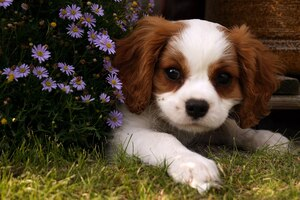

In [ ]:
fn = Path('samples/puppy.jpg')
Image(filename=fn, width=200)

We create a `Chat` object as before:

In [ ]:
chat = Chat(model)

Claudette expects images as a list of bytes, so we read in the file:

In [ ]:
img = fn.read_bytes()

Prompts to Claudette can be lists, containing text, images, or both, eg:

In [ ]:
chat([img, "In brief, what color flowers are in this image?"])

The flowers in this image are purple.

<details>

- id: `msg_01NfNgMELxrUDPhJZLYcs7Dy`
- content: `[{'citations': None, 'text': 'The flowers in this image are purple.', 'type': 'text'}]`
- model: `claude-sonnet-4-20250514`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 110, 'output_tokens': 11, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

The image is included as input tokens.

In [ ]:
chat.use

In: 110; Out: 11; Cache create: 0; Cache read: 0; Total Tokens: 121; Server tool use (web search requests): 0

Alternatively, Claudette supports creating a multi-stage chat with separate image and text prompts. For instance, you can pass just the image as the initial prompt (in which case Claude will make some general comments about what it sees), and then follow up with questions in additional prompts:

In [ ]:
chat = Chat(model)
chat(img)

What an adorable puppy! This looks like a Cavalier King Charles Spaniel puppy with the classic Blenheim coloring (chestnut and white markings). The puppy has those characteristic sweet, gentle eyes and silky coat that the breed is known for. The setting with the purple flowers in the background makes for a lovely portrait - it really highlights the puppy's beautiful coloring and sweet expression. Cavalier King Charles Spaniels are known for being friendly, affectionate companions. Is this your puppy?

<details>

- id: `msg_012EUxr4jb4if47WcA9tCt49`
- content: `[{'citations': None, 'text': "What an adorable puppy! This looks like a Cavalier King Charles Spaniel puppy with the classic Blenheim coloring (chestnut and white markings). The puppy has those characteristic sweet, gentle eyes and silky coat that the breed is known for. The setting with the purple flowers in the background makes for a lovely portrait - it really highlights the puppy's beautiful coloring and sweet expression. Cavalier King Charles Spaniels are known for being friendly, affectionate companions. Is this your puppy?", 'type': 'text'}]`
- model: `claude-sonnet-4-20250514`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 98, 'output_tokens': 118, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

In [ ]:
chat('What direction is the puppy facing?')

The puppy is facing toward the camera/viewer. You can see the puppy's face straight-on, with both eyes visible and looking directly at the camera. The puppy appears to be lying down with its head up and oriented forward, giving us a clear frontal view of its sweet face.

<details>

- id: `msg_01BrLXDv8Ka8zTDYaMRrHB4a`
- content: `[{'citations': None, 'text': "The puppy is facing toward the camera/viewer. You can see the puppy's face straight-on, with both eyes visible and looking directly at the camera. The puppy appears to be lying down with its head up and oriented forward, giving us a clear frontal view of its sweet face.", 'type': 'text'}]`
- model: `claude-sonnet-4-20250514`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 227, 'output_tokens': 65, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

In [ ]:
chat('What color is it?')

The puppy has a chestnut (reddish-brown) and white coat. The ears and patches around the eyes are a rich chestnut or reddish-brown color, while the face has a white blaze down the center and the chest/front appears to be white as well. This is the classic "Blenheim" color pattern that's common in Cavalier King Charles Spaniels - the combination of chestnut and white markings.

<details>

- id: `msg_01CQHNTxEmmDQTRe4iRM8nJk`
- content: `[{'citations': None, 'text': 'The puppy has a chestnut (reddish-brown) and white coat. The ears and patches around the eyes are a rich chestnut or reddish-brown color, while the face has a white blaze down the center and the chest/front appears to be white as well. This is the classic "Blenheim" color pattern that\'s common in Cavalier King Charles Spaniels - the combination of chestnut and white markings.', 'type': 'text'}]`
- model: `claude-sonnet-4-20250514`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 300, 'output_tokens': 103, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

Note that the image is passed in again for every input in the dialog, so that number of input tokens increases quickly with this kind of chat. (For large images, using prompt caching might be a good idea.)

In [ ]:
chat.use

In: 625; Out: 286; Cache create: 0; Cache read: 0; Total Tokens: 911; Server tool use (web search requests): 0

## Extended Thinking

Claude >=3.7 Sonnet and Opus have enhanced reasoning capabilities through [extended thinking](https://docs.anthropic.com/en/docs/build-with-claude/extended-thinking). This feature allows Claude to think through complex problems step-by-step, making its reasoning process transparent and its final answers more reliable.

To enable extended thinking, simply specify the number of thinking tokens using the `maxthinktok` parameter when making a call to Chat. The thinking process will appear in a collapsible section in the response.

Some important notes about extended thinking:

- Only available with select models
- Automatically sets `temperature=1` when enabled (required for thinking to work)
- Cannot be used with `prefill` (these features are incompatible)
- Thinking is presented in a separate collapsible block in the response
- The thinking tokens count toward your usage but help with complex reasoning

To access models that support extended thinking, you can use `has_extended_thinking_models`.

In [ ]:
has_extended_thinking_models

{'claude-3-7-sonnet-20250219',
 'claude-opus-4-20250514',
 'claude-sonnet-4-20250514'}

In [ ]:
chat = Chat(model)

In [ ]:
chat('Write a sentence about Python!', maxthinktok=1024)


Python is a versatile and beginner-friendly programming language known for its clean, readable syntax and powerful capabilities in web development, data science, artificial intelligence, and automation.

<details>
<summary>Thinking</summary>
The user is asking for a sentence about Python. This could refer to either the programming language Python or the snake. Given the context and the exclamation mark, I think they're likely asking about the programming language, but I should write something that's informative and engaging.
</details>


<details>

- id: `msg_01JfYcwwiZs7z7PFxJs9MWhk`
- content: `[{'signature': 'EskDCkYIBBgCKkCUqexxwrC1V+xRbKGIxRvIK5MA5emv++qa5nbP/DA69+/Vfy9tL0Vitr+Vqrn3MfoQM51k/izY2i3GVIQWnrC/EgyWjHiskZ5kBPWg5OYaDDPwWRnRqE2hxGoWYyIwigSZwFkpo5d+cRiN6cGyhXHvJhqXkfa6EZxILk4kCnc/FfYmpZHtxUfmsWEixYWwKrAC5RhZMGWZSvwHA/3DgrDqai+4ky+rvzBO6Prk440WN99BUsOthyllg0g1CtI4cqLo61rV+om4MW/S/qaSIbtdGkZoc1IuFc9z2SbhcM6lC0gu+nyGKzkThGJ5GlBEPTbhlwp9kpsz8qhxcrmQLBhxXHHpARLXEpqgu1KHQBhaWcHnSkIUYiBCrL1HhMRXCkI6OzHbJW52Lvk0RMxJfLEkZNvoDNjhOz+xEOIOQ1ts3gNbTCZVgwscdgZRSCcWZkv8cxKJ2Jz5OUmhGeeWXLcLdxXdTmwUKqKtbRB3B1OupWH8dFndc/f2wj5Thu8fANhCu5kfMHFk5MDTC6zxlRCGXYJfAuNOLedAr46ocvH/8xoKKr3amfZ6pQsFSG1vunk1foje5/xq95WLW7snYqM39RgB', 'thinking': "The user is asking for a sentence about Python. This could refer to either the programming language Python or the snake. Given the context and the exclamation mark, I think they're likely asking about the programming language, but I should write something that's informative and engaging.", 'type': 'thinking'}, {'citations': None, 'text': 'Python is a versatile and beginner-friendly programming language known for its clean, readable syntax and powerful capabilities in web development, data science, artificial intelligence, and automation.', 'type': 'text'}]`
- model: `claude-sonnet-4-20250514`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 41, 'output_tokens': 103, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

## Web Search and Server Tools

Claude supports server-side tools that run on Anthropic's infrastructure. The flagship example is the web search tool, which allows Claude to search the web for up-to-date information to answer questions.

Unlike client-side tools (where you provide functionality), server-side tools are managed by Anthropic. Claudette makes these easy to use with helper functions like `search_conf()`.

In [ ]:
chat = Chat(model, sp='Be concise in your responses.', tools=[search_conf()])
pr = 'What is the current weather in San Diego?'
r = chat(pr)
r

Based on the search results, here's the current weather information for San Diego:

The current temperature in San Diego is 72°F with partly cloudy conditions [^1]. Winds are coming from the north at 2 mph with gusts up to 10 mph [^2].

For today's forecast:
- Today will be the hottest day of the week with highs 5-10 degrees above normal [^3]
- Tomorrow's high is expected to be 74°F [^4] [^5]
- Tomorrow will have sunshine along with some cloudy intervals [^6]

Tonight's forecast shows cloudy conditions with a low of 61°F and winds from the WNW at 5 to 10 mph [^7].

The air quality is currently a concern, as the air has reached a high level of pollution and is unhealthy for sensitive groups [^8].

[^1]: https://www.wunderground.com/weather/us/ca/san-diego
	"zoom out · Showing Stations · access_time 6:33 PM PDT on June 14, 2025 (GMT -7) | Updated 5 seconds ago · --° | 61° · 72 °F · like 73° · Partly Cloudy..."

[^2]: https://www.wunderground.com/weather/us/ca/san-diego
	"zoom out · Showing Stations · access_time 6:33 PM PDT on June 14, 2025 (GMT -7) | Updated 5 seconds ago · --° | 61° · 72 °F · like 73° · Partly Cloudy..."

[^3]: https://www.weather.gov/sgx/
	"Today will be the hottest day of the week with highs 5-10 degrees above normal. "

[^4]: https://www.wunderground.com/weather/us/ca/san-diego
	"TomorrowSun 06/15 High · 74 °F · 8% Precip. "

[^5]: https://www.wunderground.com/weather/us/ca/san-diego
	"High 74F. "

[^6]: https://www.wunderground.com/weather/us/ca/san-diego
	"/ 0.00 °in Sunshine along with some cloudy intervals. "

[^7]: https://www.wunderground.com/weather/us/ca/san-diego
	"/ 0.00 °in Cloudy. Low 61F. Winds WNW at 5 to 10 mph. "

[^8]: https://www.accuweather.com/en/us/san-diego/92101/weather-forecast/347628
	"The air has reached a high level of pollution and is unhealthy for sensitive groups. "

<details>

- id: `msg_01AEQayCAsjuwVBB9VwhAADy`
- content: `[{'id': 'srvtoolu_01VWHZHyKmZnUe8E9MM8XmS8', 'input': {'query': 'San Diego weather today'}, 'name': 'web_search', 'type': 'server_tool_use'}, {'content': [{'encrypted_content': 'EqcCCioIBBgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDHKz20yaHo0CZVPXQBoMrES/DPbKIGyZvSzjIjCnTCU/DOVq4wqBXk5dQGNUnTvAHfD2IPXRbI0Ei7xB0rVD5pJ96v3pj85TUjP0QTUqqgEzv9fG8eTGE4eWhrDca4WuLqYkYZSUr6yjN4TXQafF0u6ruo7K5fwLGSpBR959xptm2aO4sfq6j6QNl5ql0d3yRdZpOwAT6U2Kdf5SkaJjqVD0knmR9ImBv2Mzri4Xf2g5F0i0GBjLeEhhTvoRBO7ZXPJdXz77kQPLI6pI/6Rxmv2DJqofvB1sEbnE0n1dfgCF7jGKIiMZI9HJhSaJFLVnx3xy1i+3uT5v9RgD', 'page_age': '2 weeks ago', 'title': '10-Day Weather Forecast for San Diego, CA - The Weather Channel | weather.com', 'type': 'web_search_result', 'url': 'https://weather.com/weather/tenday/l/San+Diego+CA?canonicalCityId=3b2b39ed755b459b725bf2a29c71d678'}, {'encrypted_content': 'Eu0MCioIBBgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDIs3zKO/4O6pR6VinhoMO3B6aK/+XDAld/PPIjBVW4FUgTiJlJrUOdOyDU4GJ8RsXJChaNXwnq/7d07DGqD/VaC+OPPSTG7dwl9H2uEq8AtbxY+iyFoMH7lg3Chz9SGVI6eqSAcsHNElFBz0gXuY960QA8ZGSpzLH/KwRKXtx8WyXzbLjIIjnL7ZIgza1Sb39V3SnqwczafwmLJcJj/qZ+pLcZLtg3tbOG3MPgXGavpgIw8I/nzienOWURpxMYsd2556w2vTAadmBQRtknuDazUGbfIJXWXKpnlO6m1Ydn10Q8JlTwTWNi1bbaq3uRDPIjTygaOe0qBZs8MvxAirTwWMnEmI8bzgPBFrJl9qFrMB4BNKZSzOu6Tg512sabVMzBCuGU2HkSSXEJAwoXVjtNFJqA0sj8xc0EyTAodBVCHYyBqViW+f6TUjIuNOE3cTu/IjQaiDNUmQ+bS4j7HqFFdM+YDoYeQJuKyPXwFVru/18gOY+i7mB6x7UqFH/E1AJg14+SFvij/k888qb++nc0+TsNk9Z8jqgEcCr4YnhQXxCkcmVwQF2GDkknZZTh7Iv5Nh9lm5ECYcp4fvpa4QgXXJ53CynmDUtQb4Nfxp0lguA6FbrjKMGdGJxJsElC/qYeumYCBnEMf8vJyS4RjIVrBVBb6kp7rdCf1PRkJCeGW9+7K2vWkwauooPG6JNkIVHonYtIktoPWiUgC6gA1A+th/3NqaGqqusmMd+AxmxqHl9d6LvdIQRum54dP1XjWNHYwnf9iAr8a51sezdDPh2Qkc8BLhhtJQREDFHZZaep9/lC8ts7G9SETQaNCGg/3mhs6us74FsVOO77j+Hj1HhfkqCMOkxHcuh9yuNPRZg7onO0HHq6F/CRR7nxBlBhRmZQPynjTW5gPcH+f9ydBszuiMwaPXLORyX2Td/0VcmRQ/n/D9GLE5t3TjM3YWMgLTGfUJrzu3xvi/3koU8vW6NzwazAhRGEjLMSaD95zdCUkzi5DdVVp/Sq1g20pL3SG0aI3Vr3SYKDguqeC0AFOLJYPrKND3A+Zo4/nFXsiJJNl2vqbn/DGprSCG7SXwPIrJA6CKwAet81FWriZPGnS2uR+e9HyM0YkZtPU1QimI3F3WKCfnTfTPbdWxIn6wLuPrATtyVyfnd1z4BZnvsbIIIuocDsVW1phvUbvk2CBYpazpiDakzUiUNbbmriy9gXU6PS1V+QvdeWKCL8udLLAwWs7+htxK8gRbdq7slYzO59fJHQvb0ZJyOJN5FJdhSY0cxLmMCzu7PqoKxk/p63TB5teI3XqHG2KR012qLwAP1di/x23f/rTFazQgIeyC8x8truYtVZPBXW/KL8UCV6OVIhedR1b4BWszv71pwVfiO6x/zuw239ndfWc++Pm8h5g8Hw4QG0FuVcifZ+giLIPIf7XQL6GnoGFKxMeeQvoTJNOlg8HvbdJRkRM9UB7q3Rso9no1nK/d3rxUgqyRyQMMmXxQrCXRRntaVuE8JCpsbCCm2E9OlqTDdpS/znOSCF6YO+QqQtcBE0ToV0yF23ES2waiJAS+eGikWoeTwF7+98+ocjp8dh/WA3x14KPOy9xYQMawLaJdPkCsm3TfRjvpxZOSBPHgoaZ3udQ9DaKb+mY9yZ6mNpmfh9rfO6hYqp6VEx1Ur6MjKEutxG+PE4K2F5+6dMFGm4JDiFvfteNI5LlVl21oX3Bb9ZvrihVICLGvrNl8/AC6YMY6VlZmDdTVO2LQ2OdhVOxhi5NbxBifxc50/W4eH3NGiyLCNOKa+QL8Ewg6BHiDqWSMm8PIUsMVfFTcJsrlS6xJJcD4uhYG1n60ygfv3XT7OKzYEWD6xjukophA6GaEyTXA1G05eEBeFi4gOfR1HqvAuKlxKQ9ZVwSxINATPQ2GJlVG/nqgkxIUgIGp6KfkGN4B08bZ35gI0cO4ourVieVSa6CTBB+7dlWchMpW2oKBl4v33L1NG4gRKjbWm+tlOglZzt65qKRl/NGhg0TELE+GsFnA1ITPLPUguk+fuW2WqZ4AhcQ8bCXdraa3Vn7RCQ76TXRBuWNhKEso3DYY4dM189v3MDKUSw/klzkQg8LxlekVHmBTSpMz9TcoJUZ/l8RSejOsVojv/BgD', 'page_age': 'April 15, 2025', 'title': 'San Diego, CA Weather Forecast | AccuWeather', 'type': 'web_search_result', 'url': 'https://www.accuweather.com/en/us/san-diego/92101/weather-forecast/347628'}, {'encrypted_content': 'Er0ECioIBBgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDHR8MUem9jUMg9DD9RoM7YNy4oJeHPygRCeUIjBCw31pDj8+yYrU9cxYTDJlsw307S5TPmUhqtcSMMrGKbPH3qi06BDqrzKNtE0CXnIqwAMEg4jqe+mUkkn/ThGIIHAEN+lXvJhGeEFpWdtLFfujb15WOeEGS7VbWyaApsHOKw20rAg6oqZW6ABQLVW5/NwKzFwgTl4R8FKbZ3HAK3hDsaKUXXsA4jmRjl553Ihkeq+v0ruhB8WynvoKjcnNWNvrg0ZHEJ0E2JpJcLoYuABbxvd3j3rBqcvYy8vA0xcIz2dIegsnpA13d2iJ4nTVhqLyCUPXzVS9GxsSMvYs5kYNvbbY4Dotfkc185H8GVAu9dLL+Ymq/83xQpy9TvHL4GU4j3XFSNHCH/4tEF7iyyD/FSnQHgClT+MVCXwABYVZKtZQRNCkGTNCgRdMFyCK0BzRViQtORJqQEeqQ02b7ykPvwOIbXcdM9hZD19tca+AWM/YqOWwJRfJ1lnI0jYLiXgCC0Y023qAqCMwmm3Lu3QbNWfT/Vqu9ERN0JXkXFj5CHZ7QNGupoVhQetePe/Ei+TswaNms2ft2DsNudlBCqNi0mnD8FDZ0v4bqkT5UQyDnVOO2pxy5RO8SuN4KwfPboFwtFYKKzz0wi4BX+ORrtwcP72t7phlhXJLq0QYZJZpkRp/TRgfDvMlNoxEuAhLzNGTGAM=', 'page_age': '5 days ago', 'title': 'San Diego weather forecast – NBC 7 San Diego', 'type': 'web_search_result', 'url': 'https://www.nbcsandiego.com/weather/'}, {'encrypted_content': 'EpcECioIBBgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDBSLnKsv0oY8NvwvGhoMEK4SPbrQhb4gsv+NIjAF5k++nXMk6RwvnmjpTl4J8T7mx8W8vHTjRjRfKknQ501DTBHzhqoZ+q1+LrKtsWUqmgM6PaPRLAtEEqUXkxf0YjeeF2gMLjrvvT4pV9A/xy7cGs0KTUgQtw5MQQhsrr2+ZquxKsfzEaEqq8aLfEK6ZMh39VyZDRSGdI08PyGXqrJ8CScigVIOnrOB09BNHHGLrjSysDrnP1Pu7s9GXVuBMn0uUf/+x6qBVwttDtc/zaRvpA89mIHgI4cXKrAdTgsals33uzLDjH74p84N5PWksJmHvx02BLQZco5c/sT0g/TKAFSgAtIDALiDP/DmkTBXRKzpI3BMmL5yn4ja1bFQntoHRv8Wni6iNY671szYapyHjQRDaosDA+kiHBlcQ7Vk7MfGEZ32xlQrBgCQf0QfbRgbnaVZ9+xttHJFV8iGEhAahTFF6gORvtXiLh1UymwwzbasZMoV+h8/KX03VQsOtAnvapQ18qdGldjuKMEyppEsf0fgiyJrD0qOaTJrDv4/zAPtUWSbcJwlRhDfNEKbI/JThwvC7nzjcnZvCVhnoHlP9JoWp6hXI0/jjmDXQknMEgfC5BZp3PP/HNGSdJPE24j2ghVBUxojjzqUrRgD', 'page_age': '5 days ago', 'title': 'Weather Forecast and Conditions for San Diego, CA - The Weather Channel | Weather.com', 'type': 'web_search_result', 'url': 'https://weather.com/weather/today/l/San+Diego+CA?canonicalCityId=3b2b39ed755b459b725bf2a29c71d678'}, {'encrypted_content': 'EroDCioIBBgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDIKWkJ4fF1kRsX9YmBoM4E86CYBILrIb4EQbIjBD7DfEjVA3AS2mpATAq+ZhMVGbbfL22VJDdlkJzssFDkGsumZWZBZ5qkvtjD129T8qvQIpfdpg4EVOjsGzL0u9pmIT88uZlb6r8lDdQ9BaWkCamjxitUTml9iDZhoYGVnVna7x85fwurVnR29574Jcxg2EBiR16E/1lDaAg4W9TSiSAiUUOGycTeOqO0eYWwau62fJECA8CEOgqJjWgtK07RWdAB5G9K0d8MCD3EnbkPQhTAizwVU53H5rsJgpLvDrLt2zg8R5B2xWtQFcP7c9C5P4entMH6kzKprrbBd2ax4FHFwaxn9xkBT/In8+Kek7NUGhRK+k/QtyuMeAOM2KPdVl6Ep1mSl+lm5MS3TD/13z7XaG1FNEfHTGi0iisykGln9cD7V5y7fZKh5npmnuWlMoGeyTZcHiltzWw3fL1k54zqaMWAs42xi4WFh+57dWFMc/9H60bpZwVPGL7/MB3JT9Gb5gIlIVrHj2ATFykxgD', 'page_age': '1 day ago', 'title': 'San Diego, CA', 'type': 'web_search_result', 'url': 'https://www.weather.gov/sgx/'}, {'encrypted_content': 'EoUMCioIBBgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDDlCuaO7y6kK0d0KVRoMIoYUwXbhp72ht1uDIjD/dpwoWdnsZWYGEmkoRui8gNlTqUGAsfJE14Y9Etqm6ZWd29XykZCO4HAnnw3mJLkqiAtMNEffdLA+PypQ1GDqH5ZJJS/iXlMMld0bjq/VzdXjvEC4nnHqV2aahomUPBYoHwYTkob/phvWlNrnmNiqlnHSsDDiDSVPp30s9KVKrOLdN+cVVwJuUIf+986/tFjcjt93yLNfi7qC0eSCIppIyecMYcLVbYh6wc1/u1YMPjzrWrPFMrZnq0rIGfqdBut/4Gf5SZmUVCrD1hj/h4AAGodvcsWipxVIz0g/GMAS/W+gKmefs/5SE1cqqVHZndxTHSv0qdFrULdRGP/ga4WtJsBd5I8xM7zCgG7Q0g3hmqXY6ThrLDGEIPMRZ4l2EHlQrgVs/o4IjkMMOsodyGwRxbIVzaODChs+/eXkoiZuS99tZ0l3/PNALE2tjXOAQdlE5tfyHVVN92eh1jG6XIPSqigrffklI8XrYQSe8tus3U+Wu9AszhP92/WNZE4r0tOH0zVzUe6Qoy4UJiIjNXBxxDP644TGTcpEAVR/RXWljRi0jSIa0wcAvxtnD0z8Pjzc5bGtUfQX0WvIhhNb+Ol7+AM+km971Jv9XBlrlamjHlgglLX2SrPh0MZZ+NcIP9GQUtVl8QPg7keIl6eOXqnWDqs/jh+LocGhM+iHB9s4UE/kapia4r9XK/UsIHywm61WV0ekMJ8w/jPWsmnVKrl9xTRjpvap2KlSBB+YTaQOGWjEvm5m48BVq8VKT5B6EkFT1GxhTUNVBQF5tdyweZxABv5fqZ86MFls/TJgYZLFCPNI1l9q0/HDDH3Bas4LMzjRmRsHEuhoJ8AH5NHcRSruVyvOPDAUz+tmcZZLlDThPID/4h6FJbMWmtRJUB2+wc9jX36CoctvSFRaMmzit0iJfccZuWxlnADY3fQmPUwJhCapAAXxAf1USJqCAmZcOkf60MxG9VlrH6nqwiFXUYtPhk/dFF0R8UISb5U3wKdISlLNzDYcMmfomjYiu2TCGb2ItGZzEOkVOxsam2KKg2gh/pyw/YhQtuDblnjv5tS2Q8k9ESUqHFusjar9/w/gO3Eb4IdRgZ3sFcqmX3u4pwM3F1IurQLK8DvIgRnZJAb/BX5GPwpJ9QnXAMCZDwDIPMhxcJluW/iEziU7v/JbMivt2idV7ECq7l2iJyrdfqKKe/bIlyaJBvTyfnRR86vrf27pb87vA1Hu8jHTaYVbvf5P8UwY4+GrdGSWhuw5AX5lc/0rec5flnaEhI+2gYr0siHlGk7Qwk8VvW20byAtmF38jiJHMW9+Q6nHlnCYwrVZs+gPUuOrS9/P5+O3ZNdzb4OZyNLa587F6k7xBiDqyzusWtDdSgN7ITCIoa5smCW+EQRmxQerf6GnrlJivvRSMOYI+hV6sSr+fMe7sow/LhlytZyA4Q/enW18Ndjs3H4ugd4ptX8J/lseaV8m0VqU/OkGG5dvhzfweh4Qe6z3H8uoO6tkoED1Hoc7uL8WcrI/OBfU/Rwm6gFsl3rUGHdLeKLs6J4Q/m/gnY9OzBCJO5mJMgwmrpCXUlRr/Ax1KZJ7V8akhlhJrk7J7iAFaOp9qh4CM/4CN7ii5nT4fbAqUa0HZ55wMGiTzBJsOnM03MZ8GdUDaspj1HkthttaIpJxRofo67NkRREpNaUeJUYnoO3FqmPzg5PN3TtomIWDnwODl5qRjs19C0fRqQCuwuiiV3/KKnLRF+alraj82qPB5i5nLqlaEzJeQ6VTfZTQ+PIvn4rOawST+u4g2ZpLxFlQSAlqHEVDmCFcVjNE3nWi4NQYThydzunkIOP1ZyFPKcRyXvPVpvcML0PxOrJHxy0x34HClsk7ssNBqKtQXkCbmtutC7kaIr7YfEPwI0ZO9NU42PS/s2s02JM0ZjSEiQqj3cUtr1+ox36YeolgIFdtxX2GNa0o88oI9rP/C5MYAw==', 'page_age': None, 'title': 'San Diego, CA 10-Day Weather Forecast | Weather Underground', 'type': 'web_search_result', 'url': 'https://www.wunderground.com/forecast/us/ca/san-diego'}, {'encrypted_content': 'EpkCCioIBBgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDBbVEbdxDqZj48HgPBoMPbE+4yaF2OW8KZcuIjDBjkaVtLyKCRGQdniHKvpc0zVbra4zOpFovbjCzwIhQuKjEQnHWfWBvDqJx2owi10qnAH9oBty3G5CJZfnAwrZwCemkXtU9WU34nCkR1b1R1u3OAclZk+m0Na8vlgOeNskv3DHdIsYOS559Zfq9d6PJriDJN2Q2Oc8HjIBGIo+ByH2IjNyUWugDNTZvcWq4JlEE2+98vLpYwoZm+qTtnfkTJ8XRiPMlakofn9RNpSUNvQssTT7naRF1HtD1NcuKhl4tpvMj8EU3WOpVKHRwn0YAw==', 'page_age': None, 'title': 'San Diego, CA Weather Forecast | KGTV | kgtv.com', 'type': 'web_search_result', 'url': 'https://www.10news.com/weather'}, {'encrypted_content': 'Eo4NCioIBBgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDH1hONCxZ/We6toF9hoMBW+mwHVfjP9qK94cIjDdEjUYStO+OeSDY9Nti2qpUZ9Yfs8oIahj0yVTwhI4zTpJwI6YEwSnGBGYqSLZfv8qkQy4OAV/AeysRDD3Vhz0giqlp+VWg5YNHQry5gvUBR6WCtiqYWBkjN7yuS0fPwZY8cziOko+9pvWA2ahe3VoOWuG4U5LDvTCRbn0X5ls9gBCErt725MWoabuxbJS3YnfLhR2WX4fJUmMmBO5iW5scZ6Y54Efcqa8MLhDyFezTD9z26e7mZPEognzfGN8iK3HxxqQsFiZZpCP7iO07sFPX9g3rpZmR24fWCi/zh+lRe3uTZXMQ99tbxJSmHedZakqmyejBU5k0OijVlQ2xfOnDydJ1jDTTDDofSnrIljl1IXCsv59oatExtSICyrE9kS8XUX+bB/z4/Aad9L3lIyQuC96Y3XNFyMKysY70FXK8FIsZSgoyLxgaU5zK/bejjF3Ew3zhq6WVdYAPBPJPEtL4LRJIQ9UwfTmbJymDi85FvqmmmHwPRbgj6ij98SivbDzzXG2hr0DMnBxlhTI7yz+IYU6lPN1k9MEyT59OGK55tX3c1wT0roUllNK1HR3a4JV1iJyRDrzj5F49ma6jqzx2WMdVF+z9+03nHbJCkYyQT92HFee/k9l4lCC86S4OBJF0bhWDjapDEVD+qdQIPLUpvhfYOJKs5SqUWZoAkju8BxwwkUa7lgNA/E+lQPvQB7JgrCCKbTVZd+SHrIXLuzzUAlR0TwLCHq/sV7c1Jc5Bf1wqVAQyJxr7G2UgwgTU/g5C0I0dtaO3O9npw91ElhPtnBkBXrcwKhQmIkhCik3VgAPez59NYR3g7QvtZWBNk2kQdSXtumQ5vDvIBDza3ghdKEtz56WCCktSuA6UpYNaf9MXerFkjyzkJXKdvFfLT+kYzdgcREIygAxoookJP0KUj1zDJh4MPwTEoV912Tn+r5SY8uK1O0DOpb9IRauauAwoujTJwbOQO5Mhej1M0qBzgMK+hnIQgFwkBHMB6j7FATyVeWhnwizh+ZaxYASF+pMKV7sdgGT9rqzb1pbdg4MGNbzWx++UPKAxgfGeS7hsv3GfbKyVFEzOL0PE9/Iuj/0pTWwxY3CVcjXFcicAooRnGiYXWGsd78UZOlrMTmhNtSH2gC0EyLjUYsdVQWRBEvkvyIXybLGfsC5IpViS/yb5ZwO8kq0MncFlicuaixnY6lCrcxrRbsSYjnm81OkpWLomFlwsrAzp0ChZs80MG5XCCiBQXpdD8sOJoHFYqBETXJmBTKyFLUG3g91qMV0aFYqbDr4d4zHDu1DlzNJhzmNooCampO6/qN6zNKl1YS/d5Ldo1cFW/MK8R0R3b/2FpaD3NGPTowKOygqqvmcSXsstCVscJHX/A6aqqix0Qww4TwpMcHDpcaYgmaKy19lMjknyBv1f8iJUGQzYgM7xzIQNI5V7lQf8fSZBK6sLqJ1yxHq7hLca6TUsdQwGIzKoV0BpFOulpOJ/aYg5xmcj8XdttJ/57YvDskf7DNZbPI1gG8ZffyyY9cll9yzuDpEMv/O8ajS82WP5O0G0g62WrV9vhTUogqG1rQ6wjNjdGBpbjbj96qcvJWFRGoniK9R3qnxKbT2/WpuEx/unxvO+Dov23DGVkxjWqIzEOcNYefHjOgA5LI/QyYuNYIgeA+RqmCIf3A7jd9cigX7hBrBDdYZnV4tbO/nAKtxqDgdzerdhxuAqUZNoSpHiQbGXmWb2WKomZ0KnVe/8LBBTPN4YWPPjmYQfMvI7+b1hqFPhQCJyEwoAmID93m8mvcvRaxfMLV9kJsqDOg4+5RyOlOsNxRd7SZptueXFBWQamXDExmLEEcKHzG+LSTnrptpFOaCJDyA8SGxkp3XHd+xHVWPWVfd6rRtsfXblBDksoi6lOAOeAca0lWddVEyraQ4/tYelpPodgVGnmluR3X4cCiGQyn5gYk0/L/vJvdYf3/eIbJOH3bXOLpgamH/R+fie4+YhkLNI4RTx8z5m0zbkrpaZDLwkhwbH9avvjSC14wDjKwid0muKm0gLlz9QQTB4j0BdJSxVFH/+MWz4eDDTWL+qxzt92gjrRRNnEqVTdaWdFJyL7nnzmd54TkJ94UuzzPRpFeojJWesPE69kcvpkH0FsS6gwqQJxgD', 'page_age': 'April 12, 2025', 'title': 'San Diego, CA Weather Conditions | Weather Underground', 'type': 'web_search_result', 'url': 'https://www.wunderground.com/weather/us/ca/san-diego'}, {'encrypted_content': 'EpQCCioIBBgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDGDYhNAePU5klbZmuBoM/q4J2NJNR6ZZARU2IjCLRmcLZZplcMuKPblzydk1+/kF9Ipe6P7CUm/ZUPGTwFiGUuWlnKYTrVEcFBLUd9kqlwHrSc3kBNdF+lNFmjoe0HU9Yp5LwBJUQ1zxTJ8jlgLkTKVR/enryGgmakPqrkW3lw8zd52GIRqjLxDKZPq6Ow5NxbDo+TGNmh2B9DBhsXJFwoVJ9bjv6Xm1mz6AKpmLJz1BHNqrLxAK2+tsjH1BEHTtsgDNHOmCSf66i8+Yl6okfWDbbM7zwbv6O1gRyRLX8ungltGM/bpyGAM=', 'page_age': '1 day ago', 'title': 'Hourly Weather Forecast for San Diego, CA - The Weather Channel | Weather.com', 'type': 'web_search_result', 'url': 'https://weather.com/weather/hourbyhour/l/San+Diego+CA?canonicalCityId=3b2b39ed755b459b725bf2a29c71d678'}, {'encrypted_content': 'EuANCioIBBgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDDP0YN9PtrFGfdDhChoMkmbYYAahaxhHfhwfIjClpJ8XsEcQJesq+9/vVhFcLvdhNP6Oim2WRP7/kJXRscsgDwWcn665yKaCNnnSRkwq4wwZqLSKKF2ye0uwjIBkc/DlG7DFrf9eQfEJHm1zWjhImOhsl2tGrcuebvfjkFaMNNUG8rxBF21jGly+fyTiKGHa4uKC/SV88Tp2qLxzIxj01u5sH2s9Y5S8BQXQCpdmzDxd+ufFx/aijHjta6qzvAL4qV3uojajL58H4fFpgwVHZi1kwLRigtuULcsdUzV0yRJsH4yJriDeGYXCtrZ7d6d3lx5jqSuFWbK6MmZvZmi0Q/TIOK2YQqiy6UlxKzZuWnx66neXRBPxokAZwrjCZe00dlRjmM1KI/z7vTg1Vt4gtLAEaXij4Zfp2Jv9UI6NLGqafrv4tuPETFRvstmV1AlspRp3e2wpNOmjC/WoPZxwM9Qgq9d2EddTKDzyh6WA4CBBf2SdbfbZk7N2pfd7a9JasNEW+Ca9Y7cOLF3nnISYs4drh96Znf0rfvGqIO8sUxp674rehr7gdZS4QM0/0yQTHhHccRME5c2S+772R+6yz4Hdvf99+o9KCxwSi+S0yyCPiXv+IT2r/7WvRxSXNpR1ye32Qb0q/hEAA6ve5I/VHmFYpNDYwiWLT6BgoKi+KrFVpgE/L4qLf6y9EyCXy+IkK64J7Sv8s89UbPYtIpv9Z9JOZvPizdFv/CwgxRJcmH1wOT+MuLIDvmX2rcHyTLf5sa8yult0aYhKsWjRJo2msvGC9piE/4APCONUCGexYAM0DqBh0PpDVal8N4Co186e+Er8mMyZmfSyxM11MRcWpwBmC1+n79H0q9JPa88W3k5F3iXApZ9+R+vld4Nacu+tvMyxrKzL82/IIyY+XN+q56ym4tNV4qTlUx/l9qk46C1Aet+cELuMWT1+e3XOMmWfnzISyn2iQRX1invytNoItJufPidUGzB/aFWZnwDmLyJSC6uttVcPYKMc0a2Hp+i7dLYHc8jOThiT0jr7xjx1z8KPS6IJo8yhXtAHcOhuY+yCjhiDxJNRCjf2kByURNiaiXItYZSScVMaWDQJeeai+WwgS5co4CXhY+UC5T7oTSLnWtr4NtLCLLTuro+01s470VBhxYhfHZzOnWTeFoSV+ECYJQ+5kI9MvUHlWeYEX0uIQ8GoZqriKuxTXnvLvgDMXKL2FWkqsjXSI7zmqUO0qSIqFm00RPzx9+xHtx2O1JXaDLxm7HKvewU2kwoBdpO93FQN4oqFqu9HnkhjV7GIrghRuorXRq7xGV41La/2AQnynpk4EtDCwjGsfMJFcUoYPtl8WUTGzdMlzQeMqQXTGQ23sJ3o6lzC+xJbS3r1Xl8bBCjDkX3Fn8GkAeAiqYWtxs7N6aIoX7fXP8E8wV0NMzCl3m4w3JsjB443HhyYthltNLLyXJAIuSXgoG04L8DTw/ct8+NhRQnhU2g91irPkRJ3E1+rFrqinqww/P7LAQ4IWHdQuc9sgCBuw8cdd5CbNaGcI7kUAgggWTzEpLVyoc4NBxCaT3eY46/4IqPR0JJ+OippZO4AWf1uMw4Q4NS8OkCdqIJv2k6wrOh4s/rdx///r4f9PzhcXy6+ZPTy/dNgvBZTItKXd5r3vjXCVc7PKgXpB3RdFd3qrJpjK9u3M3SbsUXC2D6GsbTyLuosvEZqgYoyfYr7qtEzJeIjksHYZKVdbkhs2rQxLlq0UhIzgzUv+pHb/GTmVjLuNUNfPb9UwM+vo00i1olbCsn+TTQsAIsRfcR58BQrPRiHEQvtdi8l7UDVzh+fOzi4gHDrddyVvo9LGluwmPHNjf1t5nldJCqVcx8F5o5j/ad03LGQ5WvBQbrCpODoQhT+KKEWIBavyV+gLsV33odj8lpqWubFVdCIGYb05ItqgO9y08FGE1zk3fpi8jok1Si0vW0KrsoPsm4u+/+KTpBYfJx4IYHHlVtvfZa/mEFCyFvFVnW00q2/ZGS34gNED3GvZy6j+EZnnLWiaFOhf/ufD1+wxOXpsnZeBJX+yFdIOdj4lakbvOMR4IXuTNf0QQhoYCEL8bR+NIMyUvRAyJZYS1Bcx7A7y0xsVSgAQJT7d2hQsMLxIXIITtukmrP5PAsVPFLrWDIQSVSM6uWSCM4GcIkJv47u9eHm5v+VyQIxG43FjihsAeSmJ0WCI/ENWDa8EKnNDjKoaBaqECrqG6T0Yo9Vrx/l2orGtYvmuwx8BepO/15OeBUOw+AylfA1iCPvmShFlpgKA0AYAw==', 'page_age': None, 'title': 'San Diego, CA Hourly Weather | AccuWeather', 'type': 'web_search_result', 'url': 'https://www.accuweather.com/en/us/san-diego/92101/hourly-weather-forecast/347628'}], 'tool_use_id': 'srvtoolu_01VWHZHyKmZnUe8E9MM8XmS8', 'type': 'web_search_tool_result'}, {'citations': None, 'text': "Based on the search results, here's the current weather information for San Diego:\n\n", 'type': 'text'}, {'citations': [{'cited_text': 'zoom out · Showing Stations · access_time 6:33 PM PDT on June 14, 2025 (GMT -7) | Updated 5 seconds ago · --° | 61° · 72 °F · like 73° · Partly Cloudy...', 'encrypted_index': 'Eo8BCioIBBgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDPU3R9AtZ/LVo3YCFBoM1xUvWDAm6CzFWEAfIjDsVvsuj59q7J65GWztTvEXzAlWs7ubIa7StdvoXmMR108a9T9dCcEuxLb/wSQXkpkqEydf33YC1e7+QgBONMxDMn9xq38YBA==', 'title': 'San Diego, CA Weather Conditions | Weather Underground', 'type': 'web_search_result_location', 'url': 'https://www.wunderground.com/weather/us/ca/san-diego'}], 'text': 'The current temperature in San Diego is 72°F with partly cloudy conditions', 'type': 'text'}, {'citations': None, 'text': '. ', 'type': 'text'}, {'citations': [{'cited_text': 'zoom out · Showing Stations · access_time 6:33 PM PDT on June 14, 2025 (GMT -7) | Updated 5 seconds ago · --° | 61° · 72 °F · like 73° · Partly Cloudy...', 'encrypted_index': 'Eo8BCioIBBgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDA41rePEI0CRgFL3axoMrCZIbsv0WkAu0cAXIjDIPvdld5E9ldsFaYSiJuoT1yjJHnoM8FTnGbKi/1l93MDB7Bwn0v1SploMsrksUMIqE6/F18439pvxUORPn+pYyxup690YBA==', 'title': 'San Diego, CA Weather Conditions | Weather Underground', 'type': 'web_search_result_location', 'url': 'https://www.wunderground.com/weather/us/ca/san-diego'}], 'text': 'Winds are coming from the north at 2 mph with gusts up to 10 mph', 'type': 'text'}, {'citations': None, 'text': ".\n\nFor today's forecast:\n- ", 'type': 'text'}, {'citations': [{'cited_text': 'Today will be the hottest day of the week with highs 5-10 degrees above normal. ', 'encrypted_index': 'Eo8BCioIBBgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDNNNx2xUZCHWK1hC2hoMd1yb2PuH0/R8HUQ2IjB80Kgi4D79CvRJcrmtn4+z7ZzUM+vmF5e0IBczymYd+OXFGq/niE91cXlNRCaYCzoqE8RGcIsDgZFaCgTKCSRRyL5MQB4YBA==', 'title': 'San Diego, CA', 'type': 'web_search_result_location', 'url': 'https://www.weather.gov/sgx/'}], 'text': 'Today will be the hottest day of the week with highs 5-10 degrees above normal', 'type': 'text'}, {'citations': None, 'text': '\n- ', 'type': 'text'}, {'citations': [{'cited_text': 'TomorrowSun 06/15 High · 74 °F · 8% Precip. ', 'encrypted_index': 'EpABCioIBBgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDNzm/Mcg1g6QM6galxoMJ8HeJhv6g8BGPbmRIjDmAiQoDAvSdXE73w70YaAWjabB9aAzMWul00u8PVPUmEMSCKox1e6MF+VEUuzktaEqFKL5S2hXDlTIqo+Hf36H16+EX6IlGAQ=', 'title': 'San Diego, CA Weather Conditions | Weather Underground', 'type': 'web_search_result_location', 'url': 'https://www.wunderground.com/weather/us/ca/san-diego'}, {'cited_text': 'High 74F. ', 'encrypted_index': 'EpABCioIBBgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDKDAkGHRvRIM8RwJlRoM36OX/mAB+6ZWPD3TIjAVtyEeK0tBbFb0fWi0Q/DryoCb0G0vSevc3zOhimofckJg77Tm42UxbYusBFeFAmUqFE07pgpE2x1jkl0xmmlCsxhVUGDHGAQ=', 'title': 'San Diego, CA Weather Conditions | Weather Underground', 'type': 'web_search_result_location', 'url': 'https://www.wunderground.com/weather/us/ca/san-diego'}], 'text': "Tomorrow's high is expected to be 74°F", 'type': 'text'}, {'citations': None, 'text': '\n- ', 'type': 'text'}, {'citations': [{'cited_text': '/ 0.00 °in Sunshine along with some cloudy intervals. ', 'encrypted_index': 'EpABCioIBBgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDMSJPiSRDMQVdwvZIxoMv51tzzFbuOvBRyp5IjChdKKfwJq5F/g7nfbpd+Wk/wghE0ZtKVkEqL9xxvWtao4UVdbDe38q/so1mlGoWeQqFHB6p8TLZxX8a9y8aptzrAzWBAkSGAQ=', 'title': 'San Diego, CA Weather Conditions | Weather Underground', 'type': 'web_search_result_location', 'url': 'https://www.wunderground.com/weather/us/ca/san-diego'}], 'text': 'Tomorrow will have sunshine along with some cloudy intervals', 'type': 'text'}, {'citations': None, 'text': "\n\nTonight's forecast shows ", 'type': 'text'}, {'citations': [{'cited_text': '/ 0.00 °in Cloudy. Low 61F. Winds WNW at 5 to 10 mph. ', 'encrypted_index': 'EpIBCioIBBgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDPU8Khn9VdAypd2ZcxoMr4NEjs7R6WFHRDAmIjBy+bA5mTF+9ROtLEE8lWG9oIIGQn/uApco3yX09hJQ9H62CA48xfQp8R+nLDrUkG4qFjYpYXfMEvxpDFOmisuCbnrxlFu34vMYBA==', 'title': 'San Diego, CA Weather Conditions | Weather Underground', 'type': 'web_search_result_location', 'url': 'https://www.wunderground.com/weather/us/ca/san-diego'}], 'text': 'cloudy conditions with a low of 61°F and winds from the WNW at 5 to 10 mph', 'type': 'text'}, {'citations': None, 'text': '.\n\nThe air quality is currently a concern, as ', 'type': 'text'}, {'citations': [{'cited_text': 'The air has reached a high level of pollution and is unhealthy for sensitive groups. ', 'encrypted_index': 'Eo8BCioIBBgCIiQ4ODk4YTFkYy0yMTNkLTRhNmYtOTljYi03ZTBlNTUzZDc0NWISDKF9ybgNYmB5g+C9HRoMY18Fw7KwCXkOLW1mIjDntHUUhAH2H7Idj0clzgP4yhDgEsaCjjrtVgENw+huk55ghkqe0qa4L7Co6d6fRLwqE0LfaeIBD8nP/N6IL9vPgxmLX6wYBA==', 'title': 'San Diego, CA Weather Forecast | AccuWeather', 'type': 'web_search_result_location', 'url': 'https://www.accuweather.com/en/us/san-diego/92101/weather-forecast/347628'}], 'text': 'the air has reached a high level of pollution and is unhealthy for sensitive groups', 'type': 'text'}, {'citations': None, 'text': '.', 'type': 'text'}]`
- model: `claude-sonnet-4-20250514`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 8618, 'output_tokens': 358, 'server_tool_use': {'web_search_requests': 1}, 'service_tier': 'standard'}`

</details>

The `search_conf()` function creates the necessary configuration for the web search tool. You can customize it with several parameters:

```python
search_conf(
    max_uses=None,               # Maximum number of searches Claude can perform
    allowed_domains=None,        # List of domains to search within (e.g., ['wikipedia.org'])
    blocked_domains=None,        # List of domains to exclude (e.g., ['twitter.com'])
    user_location=None           # Location context for search
)
```

When Claude uses the web search tool, the response includes citations linking to the source information. Claudette automatically formats these citations and provides them as footnotes in the response.

Web search usage is tracked separately from normal token usage in the `usage` statistics:

In [ ]:
chat.use

In: 8618; Out: 358; Cache create: 0; Cache read: 0; Total Tokens: 8976; Server tool use (web search requests): 1

Web search requests have their own pricing. As of May 2024, web searches cost $10 per 1,000 requests.

## Text Editor Tool

Claudette provides support for Anthropic's special Text Editor Tool, which allows Claude to view and modify files directly. Unlike regular function-calling tools, the text editor tool uses a predefined schema built into Claude's model.

Important notes about the text editor tool:

- It's schema-less - you provide a configuration but not a schema
- It uses type identifiers like "text_editor_20250124" specific to Claude models
- You must implement a dispatcher function (in Claudette, it's `str_replace_based_edit_tool`)
- Different commands route through this single dispatcher function

The text editor tool allows Claude to:

- View file or directory contents
- Create new files
- Insert text at specific line numbers
- Replace text within files

In [ ]:
from claudette.text_editor import text_editor_conf, str_replace_based_edit_tool
from toolslm.funccall import mk_ns

# Create a chat with the text editor tool
chat = Chat(model, sp='Be concise in your responses.',
            tools=[text_editor_conf['sonnet']], ns=mk_ns(str_replace_based_edit_tool))

# Now Claude can explore files
for o in chat.toolloop('Please explain concisely what my _quarto.yml does. Use your tools, and explain before each usage what you are doing.'):
    if not isinstance(o,dict): display(o)

I'll examine your _quarto.yml file to explain what it does. Let me start by looking at the file to understand its contents.

<details>

- id: `msg_01JoYt98njPhkyrGQKRzMMRG`
- content: `[{'citations': None, 'text': "I'll examine your _quarto.yml file to explain what it does. Let me start by looking at the file to understand its contents.", 'type': 'text'}, {'id': 'toolu_01WbX1nRkdDf12f5HaNmZyHF', 'input': {'command': 'view', 'path': '_quarto.yml'}, 'name': 'str_replace_based_edit_tool', 'type': 'tool_use'}]`
- model: `claude-sonnet-4-20250514`
- role: `assistant`
- stop_reason: `tool_use`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 1120, 'output_tokens': 110, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

Your `_quarto.yml` file configures a Quarto website project with the following key settings:

**Project Configuration:**
- Sets up a website project type
- Includes all `.txt` files as resources
- Configures preview server on port 3000 without auto-opening browser

**HTML Output Format:**
- Uses the "cosmo" theme with custom CSS styling
- Enables table of contents, code tools, and syntax highlighting
- Sets custom layout dimensions (wide body at 1800px, narrow sidebar at 180px)
- Keeps markdown files after rendering
- Uses "arrow" syntax highlighting style with custom code block styling

**Website Features:**
- Enables social media cards (Twitter and Open Graph)
- Adds a primary-colored navbar with search functionality
- Uses a floating sidebar style
- Links to GitHub issues for repo actions

**External Configuration:**
- References additional metadata from `nbdev.yml` and `sidebar.yml` files

This appears to be configured for a documentation or blog website, possibly using nbdev (a tool for literate programming with Jupyter notebooks), given the nbdev.yml reference and the wide body layout suitable for code documentation.

<details>

- id: `msg_012xrrabUu1Fh8xZSP5cuhfc`
- content: `[{'citations': None, 'text': 'Your `_quarto.yml` file configures a Quarto website project with the following key settings:\n\n**Project Configuration:**\n- Sets up a website project type\n- Includes all `.txt` files as resources\n- Configures preview server on port 3000 without auto-opening browser\n\n**HTML Output Format:**\n- Uses the "cosmo" theme with custom CSS styling\n- Enables table of contents, code tools, and syntax highlighting\n- Sets custom layout dimensions (wide body at 1800px, narrow sidebar at 180px)\n- Keeps markdown files after rendering\n- Uses "arrow" syntax highlighting style with custom code block styling\n\n**Website Features:**\n- Enables social media cards (Twitter and Open Graph)\n- Adds a primary-colored navbar with search functionality\n- Uses a floating sidebar style\n- Links to GitHub issues for repo actions\n\n**External Configuration:**\n- References additional metadata from `nbdev.yml` and `sidebar.yml` files\n\nThis appears to be configured for a documentation or blog website, possibly using nbdev (a tool for literate programming with Jupyter notebooks), given the nbdev.yml reference and the wide body layout suitable for code documentation.', 'type': 'text'}]`
- model: `claude-sonnet-4-20250514`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 1467, 'output_tokens': 261, 'server_tool_use': None, 'service_tier': 'standard'}`

</details>

In [ ]:
chat.use

In: 2587; Out: 371; Cache create: 0; Cache read: 0; Total Tokens: 2958; Server tool use (web search requests): 0

## Other model providers

You can also use 3rd party providers of Anthropic models, as shown here.

### Amazon Bedrock

These are the models available through Bedrock:

In [ ]:
models_aws

['claude-3-5-haiku-20241022',
 'claude-3-7-sonnet-20250219',
 'anthropic.claude-3-opus-20240229-v1:0',
 'anthropic.claude-3-5-sonnet-20241022-v2:0']

To use them, call `AnthropicBedrock` with your access details, and pass that to `Client`:

In [ ]:
from anthropic import AnthropicBedrock

In [ ]:
ab = AnthropicBedrock(
    aws_access_key=os.environ['AWS_ACCESS_KEY'],
    aws_secret_key=os.environ['AWS_SECRET_KEY'],
)
client = Client(models_aws[-1], ab)

Now create your `Chat` object passing this client to the `cli` parameter -- and from then on, everything is identical to the previous examples.

In [ ]:
chat = Chat(cli=client)
chat("I'm Jeremy")

### Google Vertex

These are the models available through Vertex:

In [ ]:
models_goog

To use them, call `AnthropicVertex` with your access details, and pass that to `Client`:

In [ ]:
from anthropic import AnthropicVertex
import google.auth

In [ ]:
project_id = google.auth.default()[1]
gv = AnthropicVertex(project_id=project_id, region="us-east5")
client = Client(models_goog[-1], gv)

In [ ]:
chat = Chat(cli=client)
chat("I'm Jeremy")

## Extensions

- [Pydantic Structured Ouput](https://github.com/tom-pollak/claudette-pydantic)